# GFlowNet-EM on hierarchical mixture dataset
### Katie Everett, Nikolay Malkin

This notebook contains a minimal implementation of the GFlowNet-EM method that runs on a hierarchical version of a Gaussian mixture model. The dataset and empirical results are described in Section 3 and Section 5 of the GFlowNet-EM paper.

---



## Imports

In [59]:
import numpy as np
from matplotlib import pyplot as pt
from scipy.special import softmax
import torch as T
import torch.nn.functional as F
import tqdm
import math

import pandas as pd

device = T.device('cuda')

## Setup

### Data Generation
The dataset is a hierarchical version of a Gaussian mixture model where there are megacomponents (called superclusters in the paper) that each have four petals (called subclusters in the paper) at fixed offsets surrounding the mean. Each point is generated by first choosing a megacomponent uniformly at random, then choosing a petal uniformly at random, then sampling from the Gaussian centered at the component mean (the "center" of the petal).

Only the position of the megacomponent means are learned. Everything else is fixed, including the angles and distance of the petals from the megacomponent mean, and the variance.

In [60]:
# Define the structure of a megacomponent
data_dim = 2
n_petals = 4
std = 0.25

angles = (np.arange(n_petals) + 0.5) * 2 * np.pi / n_petals
print(angles)
petal_mean_offsets = np.stack([np.cos(angles), np.sin(angles)], 1)
print(petal_mean_offsets)
epsilon = 1e-8

def sample_megacomponent(N):
    j = (np.random.randint(n_petals, size=(N,)) + 0.5) * 2 * np.pi / n_petals
    x = np.stack([np.cos(j), np.sin(j)], 1)
    return x + std * np.random.randn(*x.shape)

[0.78539816 2.35619449 3.92699082 5.49778714]
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]
 [-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]


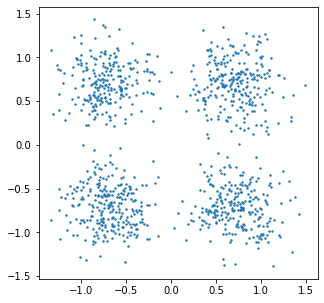

In [61]:
# Sample and plot an example megacomponent
x = sample_megacomponent(1000)
pt.figure(figsize=(5,5))
pt.scatter(*x.T, s=2)
pt.show()

torch.float32


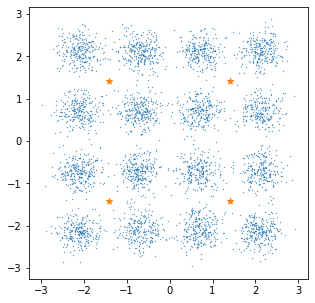

In [62]:
# Generate training data with four megacomponents in a square / grid shape
n_megacomponents = 4
gt_megacomponent_means = np.array([[-np.sqrt(2), -np.sqrt(2)],
                                   [np.sqrt(2), np.sqrt(2)],
                                   [np.sqrt(2), -np.sqrt(2)],
                                   [-np.sqrt(2), np.sqrt(2)],
                                   ])

def sample_data(N):
  i = T.tensor(np.random.randint(n_megacomponents, size=(N,)))
  i_one_hot = F.one_hot(i, n_megacomponents)
  sampled_megacomponent_mean = T.einsum('bi,id->bd', i_one_hot.float(), T.tensor(gt_megacomponent_means).float())
  j = (np.random.randint(n_petals, size=(N,)) + 0.5) * 2 * np.pi / n_petals
  sampled_petal_offset = np.stack([np.cos(j), np.sin(j)], 1)
  return (sampled_megacomponent_mean + sampled_petal_offset + (std * np.random.randn(*sampled_petal_offset.shape))).numpy()

data = sample_data(4000)
data_tensor = T.tensor(data, dtype=T.float32)
print(data_tensor.dtype)
N = data.shape[0]

pt.figure(figsize=(5,5))
pt.scatter(*data.T, s=0.1)
pt.scatter(*gt_megacomponent_means.T, s=40, marker='*')
pt.show()

### Initialization

In [63]:
# Initialize the means

# Uncomment to initialize to random location within some reasonable distance
# megacomponent_means = np.random.randn(n_megacomponents, 2) * means_scale*0.2

# Initialize megacomponent means to a random data point
initial_megacomponent_means = data[np.random.randint(data.shape[0], size=n_megacomponents), :]

# Uncomment to initialize with ground truth and check if stable
# megacomponent_means[:] = gt_megacomponent_means

### Utility functions

Given the current megacomponent means, compute the component means (the centers of the petals). Since the angles and distance from the megacluster mean to the petals are fixed, this is deterministic.

In [64]:
# Assumes megacomponent means are numpy, not tensor
def get_component_means(megacomponent_means):
    # Component means = megacomponent means + petal mean offsets
    component_means = np.zeros((n_megacomponents, n_petals, 2))  # [C P 2]
    component_means += megacomponent_means[:, None]  # megacomponent_means[:, None] = [C 1 2]
    component_means += petal_mean_offsets  # petal_mean_offsets = [C 2]
    return component_means

Compute the log likelihood of the dataset, for a particular choice of megacomponent means.

In [65]:
# Compute log p(x) per sample, where p(x) = \sum_{i,j} p(x|i,j)p(i)p(j) and p(i) and p(j) are uniform
def data_log_likelihood(data, megacomponent_means):
  component_means = get_component_means(megacomponent_means)  # [C P 2]
  log_p_x_ij = (-0.5*((data[:, None, None] - component_means)**2 / std**2) + 2*math.log(std) + math.log(2*math.pi)).sum(-1)  # [N C P]
  log_likelihood_per_sample = T.logsumexp(T.tensor(log_p_x_ij), (1,2)) - math.log(n_megacomponents) - math.log(n_petals)  # [N]
  log_likelihood = T.mean(log_likelihood_per_sample)
  return log_likelihood.item()


### Visualization functions

In [66]:
def subplot_megacomponent_means(it, total_iterations, data, megacomponent_means):
  pt.subplot(4, total_iterations // 4, it+1)
  pt.xticks([]);pt.yticks([])
  pt.xlim(data[:,0].min()*2, data[:,0].max()*2)
  pt.ylim(data[:,1].min()*2, data[:,1].max()*2)
  pt.scatter(*data.T, s=0.1)
  pt.scatter(*gt_megacomponent_means.T, s=40)  # these are fixed and set above
  pt.scatter(*megacomponent_means.T, s=20)

In [67]:
def get_best_separate_latents(post):
  reshaped = np.reshape(post, (post.shape[0], post.shape[1] * post.shape[2]))
  best_ij = np.argmax(reshaped, axis=1)
  best_i, best_j = np.unravel_index(best_ij, (4,4))
  return best_i, best_j

In [68]:
# For given data and megacomponent_means, plot how points are assigned to megacomponent means on the left
# and how points are assigned to petals on the right

def plot_posterior(data, megacomponent_means, megacomponent_assignment, petal_assignment):
  fig = pt.figure(figsize=(6,3))
  left = fig.add_subplot(121)
  left.set_xticks([])
  left.set_yticks([])
  left.scatter(*data.T, s=0.2, c=megacomponent_assignment)
  left.scatter(*megacomponent_means.T, s=20, c='black')

  right = fig.add_subplot(122)
  right.set_xticks([])
  right.set_yticks([])
  right.scatter(*data.T, s=0.2, c=petal_assignment)
  right.scatter(*megacomponent_means.T, s=20, c='black')

In [69]:
def plot_posterior_panel(data, megacomponent_means, assignment_to_plot):
  fig = pt.figure(figsize=(9,9))
  pt.xticks([])
  pt.yticks([])
  pt.scatter(*data.T, s=6, c=assignment_to_plot)
  pt.scatter(*megacomponent_means.T, s=300, c='black')

In [70]:
def plot_means(means_to_plot):
  pt.figure(figsize=(9,9))
  pt.xticks([]);pt.yticks([])
  pt.xlim(-3.2, 3.2)
  pt.ylim(-3.2, 3.2)
  pt.scatter(*data.T, s=6)
  pt.scatter(*gt_megacomponent_means.T, s=600, c='orange', marker=(5, 1))  # these are fixed and set above
  pt.scatter(*means_to_plot.T, s=150, c='black')

## Full (exact) EM algorithm
On this toy problem, we can perform the full EM algorithm because we can compute the exact posterior $q(i,j|x)$ during the E-step, and the exact maximum likelihood during the M-step. During the E-step, we compute a sum over all possible $(i,j)$ pairs, which would be intractable in general as the number of terms in this sum grows exponentially with the number of levels in the hierarchy.


In [71]:
def exact_m_step(data, qij):
  # for each i and j, weight data shifted by jth petal by qij
  data_weighted = (data[:, None, None] - petal_mean_offsets) *  qij[..., None]  # [N C P 2]
  # compute ith megacomponent mean
  megacomponent_means = (data_weighted.sum((0,2)) + epsilon) / ( qij.sum((0,2))[..., None] + epsilon)
  return megacomponent_means

Exact EM final data log likelihood:  -5.612906783394718


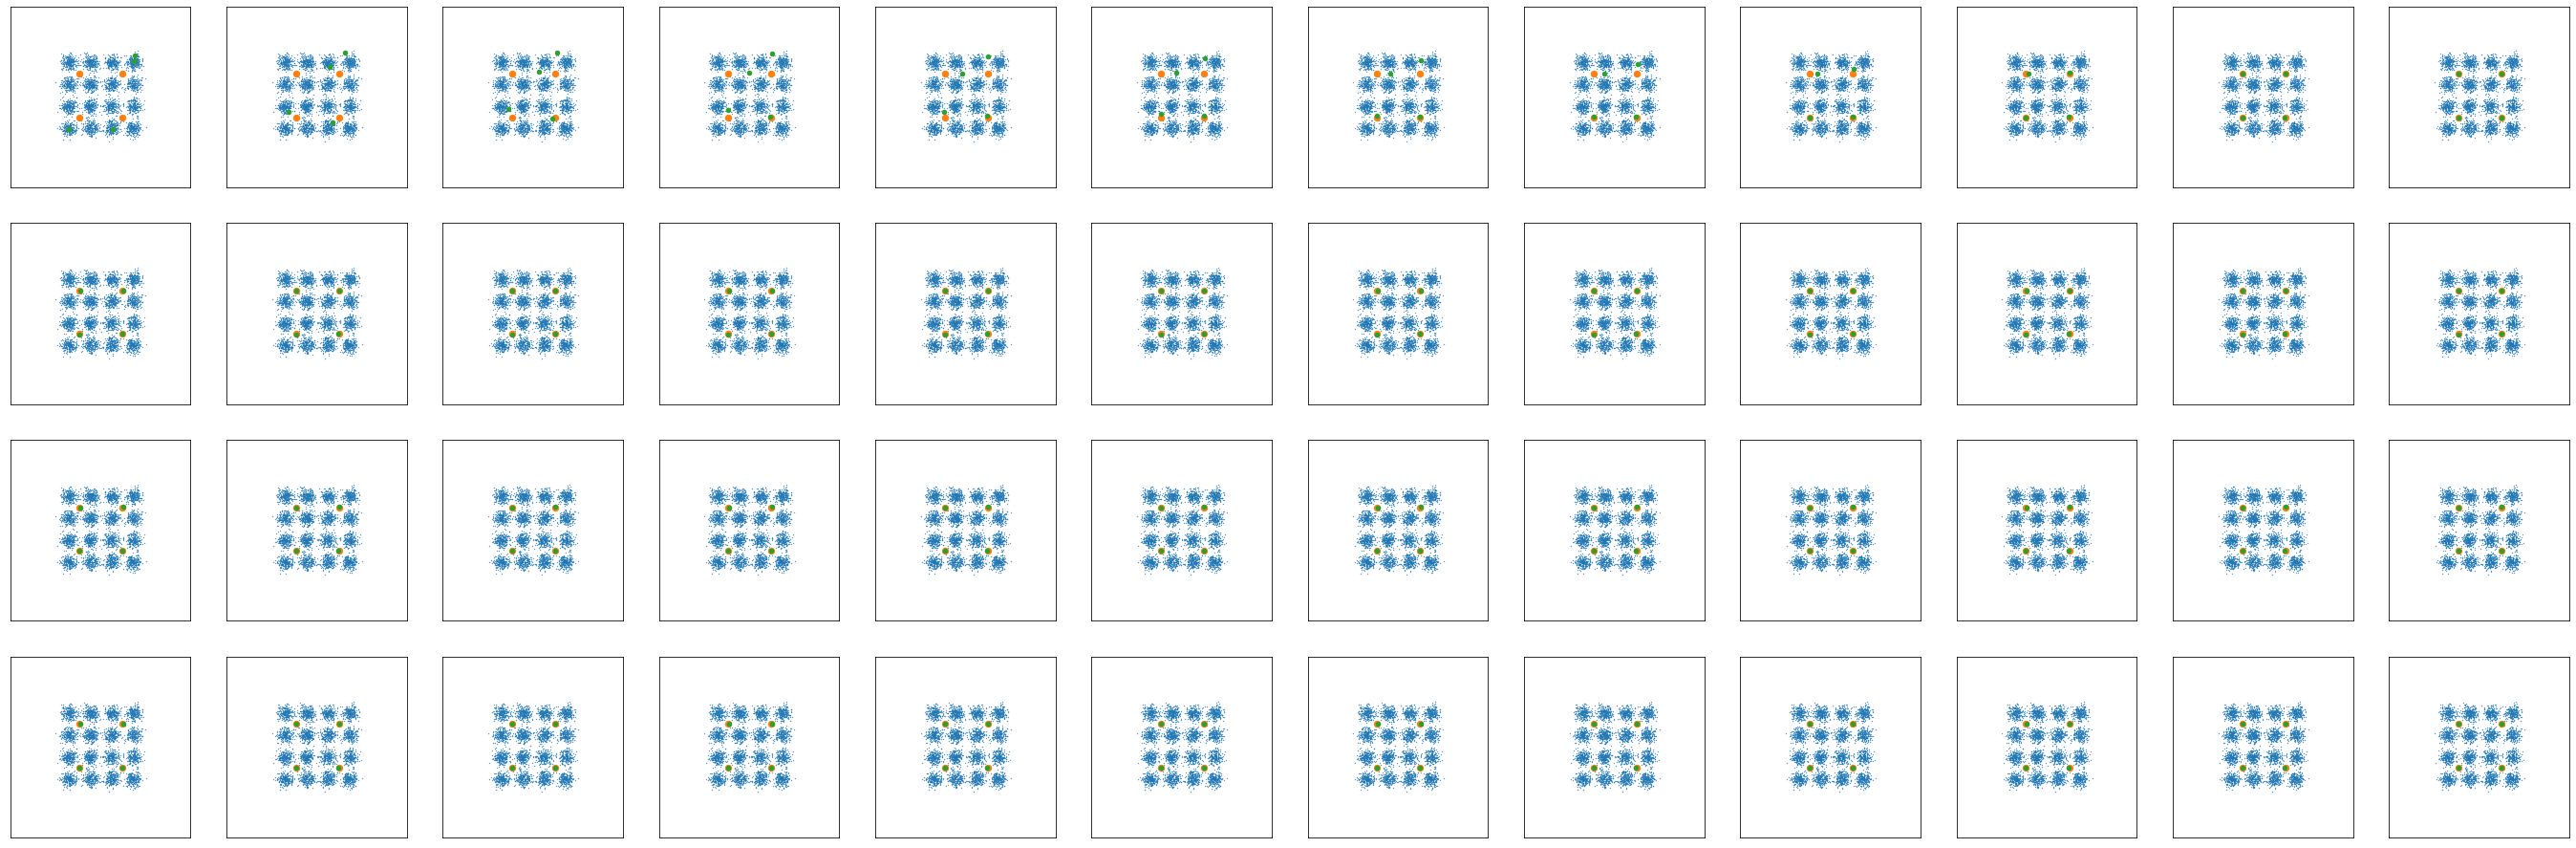

In [72]:
# Fit model using full EM (model the exact posterior q(i,j|x))

# Shapes:
# N = number data points, C = number of megacomponents, P = number of petals per megacomponent
# data: [N 2], data[:, None, None]: [N 1 1 2], component_means [C P 2]

def exact_EM(initial_megacomponent_means, iterations, e_step_only=False):
  megacomponent_means = initial_megacomponent_means
  data_log_likelihoods = []

  pt.figure(figsize=(iterations,16))
  for it in range(iterations):
      data_log_likelihoods.append(data_log_likelihood(data, megacomponent_means))
      if iterations % 4 == 0 and iterations >= 4:
        subplot_megacomponent_means(it, iterations, data, megacomponent_means)
      # E-step: update posterior

      # Given the current megacomponent_means, compute component_means.
      # Component means = megacomponent means + petal mean offsets
      component_means = np.zeros((n_megacomponents, n_petals, 2))  # [C P 2]
      component_means += megacomponent_means[:, None]  # megacomponent_means[:, None] = [C 1 2]
      component_means += petal_mean_offsets  # petal_mean_offsets = [C 2]

      # Distance of each data point to each of component means (C x P in total) for each dimension (x and y)
      dist_from_component_means = data[:, None, None] - component_means  # [N C P 2]

      # logits for posterior
      lps = (-((data[:, None, None] - component_means) / std)**2).sum(-1) / 2  # [N C P], sum is over x-dim and y-dim
      # posterior q(i,j|x)
      qij = softmax(lps, (1, 2))  # [N C P]

      # M-step: update means of megacomponents
      if not e_step_only:
        megacomponent_means = exact_m_step(data, qij)

  final_data_log_likelihood =  data_log_likelihoods[-1]
  final_megacomponent_means = megacomponent_means
  print('Exact EM final data log likelihood: ', final_data_log_likelihood)
  pt.show()
  return final_megacomponent_means, qij, final_data_log_likelihood

iterations = 48
megacomponent_means, qij, _ = exact_EM(initial_megacomponent_means, iterations)

## Variational EM
We implement mean-field variational EM where we approximate the posterior using the factorization $q(i|x)q(j|x)$. In particular, this factorization improves the scalability because the E-step no longer considers all possible combinations of latents. Instead, we sum over each factor $i$ and $j$ separately, which would remain tractable for deeper hierarchies.

Variational EM final data log likelihood:  -6.095193260186021


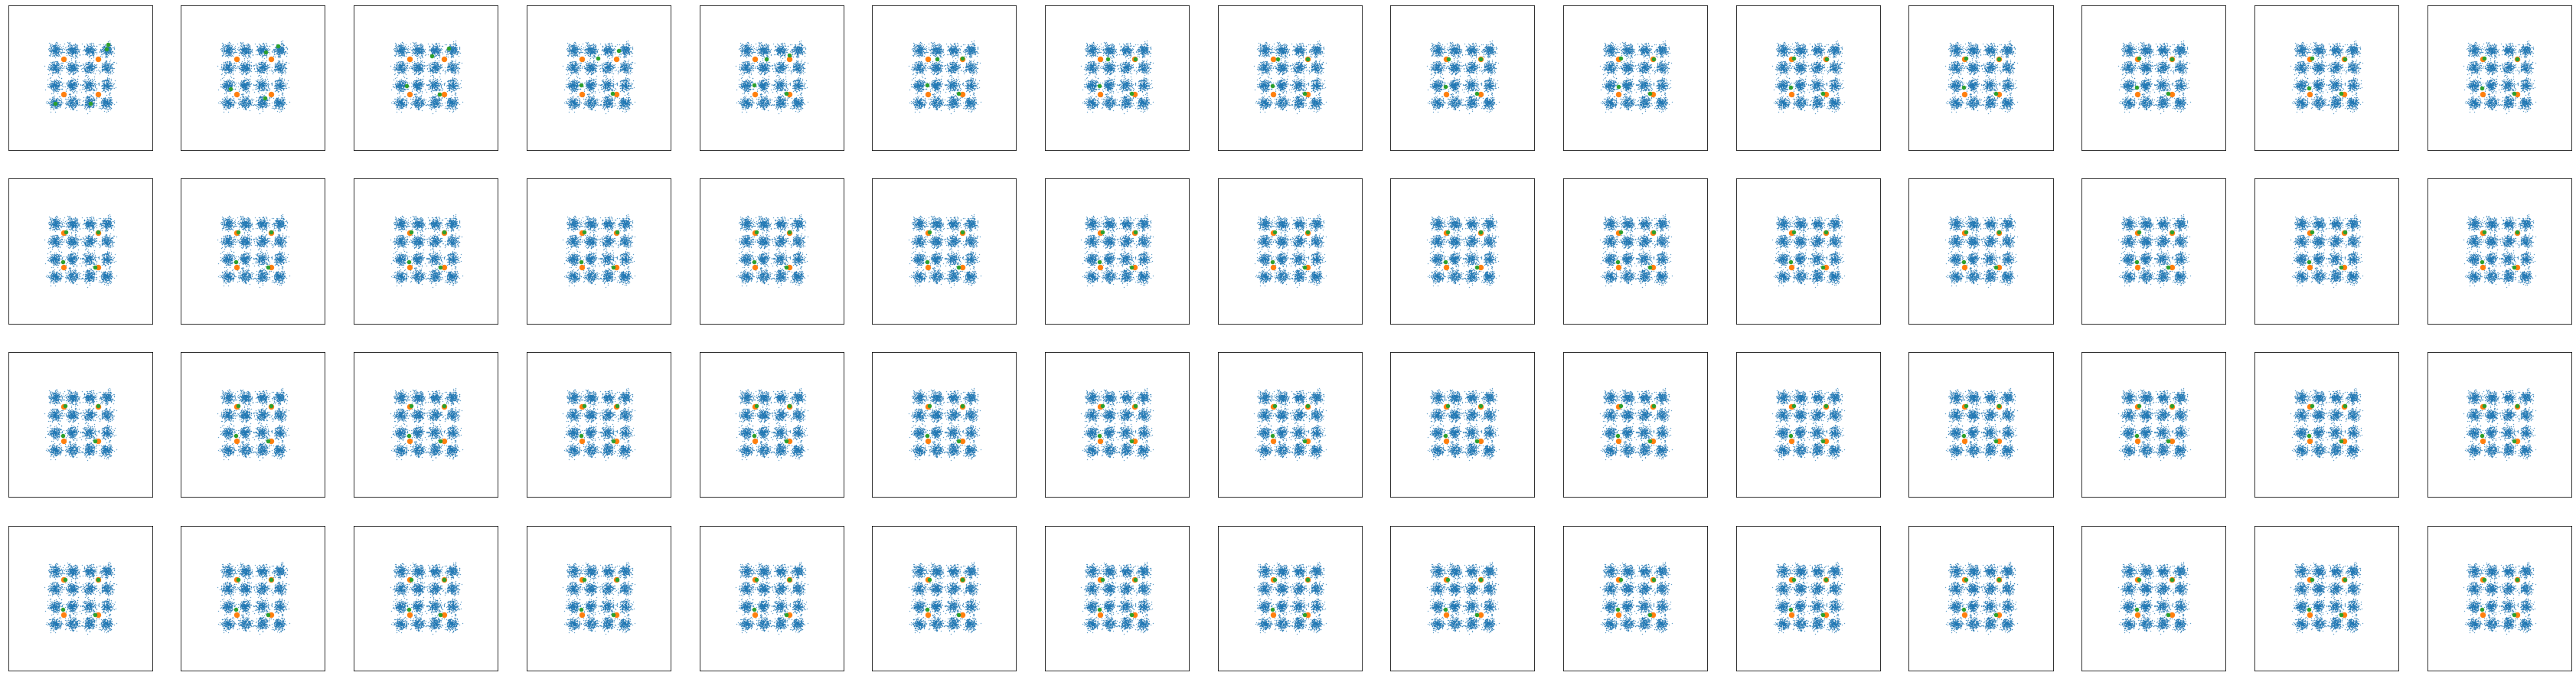

In [73]:
# Fit model using variational EM (model posterior as q(i|x)q(j|x))

def variational_EM(initial_megacomponent_means, iterations, e_step_only=False):
  megacomponent_means = initial_megacomponent_means
  q_i = softmax(np.random.ranf((N, n_megacomponents)), -1)
  q_j = softmax(np.random.ranf((N, n_petals)), -1)

  data_log_likelihoods = []

  pt.figure(figsize=(iterations,16))
  for it in range(iterations):
      data_log_likelihoods.append(data_log_likelihood(data, megacomponent_means))
      if iterations % 4 == 0 and iterations >= 4:
        subplot_megacomponent_means(it, iterations, data, megacomponent_means)

      # E-step: update posterior
      data_minus_petal = data - q_j @ petal_mean_offsets
      lps = (-((data_minus_petal[:, None] - megacomponent_means) / std)**2).sum(-1) / 2
      q_i = softmax(lps, -1)

      data_minus_megacomponent = data - q_i @ megacomponent_means
      lps = (-((data_minus_megacomponent[:, None] - petal_mean_offsets) / std)**2).sum(-1) / 2
      q_j = softmax(lps, -1)

      # M-step: update means
      if not e_step_only:
        data_minus_petal = data - q_j @ petal_mean_offsets
        megacomponent_means = ((data_minus_petal[:, None] * q_i[..., None]).sum(0) + epsilon) / (q_i.sum(0)[:, None] + epsilon)

  final_data_log_likelihood =  data_log_likelihoods[-1]
  final_megacomponent_means = megacomponent_means
  print('Variational EM final data log likelihood: ', final_data_log_likelihood)
  pt.show()
  return final_megacomponent_means, (q_i, q_j), final_data_log_likelihood

iterations = 60
megacomponent_means, (q_i, q_j), _ = variational_EM(initial_megacomponent_means, iterations)

## GFlowNet-EM
In GFlowNet-EM, the E-step is performed by a GFlowNet which learns the approximate posterior $q(i,j|x)$, where $i$ specifies which megacomponent and $j$ specifies which petal the data $x$ came from. The GFlowNet is conditioned on x with a state-action space containing two layers where the first action chooses $i$ and the second action chooses $j$.

After training, GFlowNets sample proportional to their reward function. Here we use the Trajectory Balance objective for training. We set the reward function to be proportional to the true posterior $p(i,j|x)$. Recall that the megacomponent means are estimated in the M-step so they are treated as fixed during the E-step. Therefore, for a particular component mean (the mean of the particular petal $j$ of the particular megacomponent $j$), we can compute the data likelihood $p(x|i,j)$ exactly as it is simply a Gaussian with fixed variance.

The M-step can be computed exactly on this problem, but we perform the M-step with gradient steps here to match what other methods in the paper do during the M-step.

### Define GFN-EM

In [74]:
# Utility functions

def state_to_tensor(data_tensor, i_one_hot, j_one_hot):
  return T.cat((data_tensor, i_one_hot, j_one_hot), dim=1)

def log_posterior_reward(data, megacomponent_means):
  # Component means = megacomponent means + petal mean offsets
  component_means = T.zeros((n_megacomponents, n_petals, 2))
  component_means += megacomponent_means[:, None]
  component_means += T.tensor(petal_mean_offsets)

  # Distance of each data point to each of component means (C x P in total) for each dimension (x and y)
  dist_from_component_means = data[:, None, None] - component_means  # [N C P 2]
  lps = (-((dist_from_component_means) / std)**2).sum(-1) / 2  # [N C P], sum is over x-dim and y-dim
  return lps

def log_posterior_reward_xij(cached_lps_data, i, j):
  A = cached_lps_data
  B = i.float()
  C = j.float()
  D = T.einsum('bij,bi->bj', A, B)
  E = T.einsum('bj,bj->b', D, C)
  return E

In [75]:
# Define the model

# Each GFN state (input to the neural net) is encoded as concatenation of:
#  - the data x (uses data_dim dimensions)
#  - one-hot for megacomponent (uses n_megacomponents dimensions)
#  - one-hot for petals (uses n_petals dimensions)
#  = data_dim + n_megacomponents + n_petals

# The policy logits (output of the neural net) are a concatenation of:
#  - the forward policy logits that choose the megacomponent i (uses n_megacomponents dimensions)
#  - the forward policy logits that choose the petal j (uses n_petals dimensions)
#  - one scalar that learns log_Z (uses 1 dimension)
#  = n_megacomponents + n_petals + 1

class TBModel(T.nn.Module):

  def __init__(self, num_hid):
    state_dim = data_dim + n_megacomponents + n_petals
    output_dim = n_megacomponents + n_petals + 1
    super().__init__()
    self.mlp = T.nn.Sequential(T.nn.Linear(state_dim, num_hid), T.nn.LeakyReLU(),
                             T.nn.Linear(num_hid, output_dim))

  def forward(self, state):
    logits = self.mlp(state)

    P_F_megacomponent = logits[..., :n_megacomponents]
    P_F_petal = logits[..., n_megacomponents:-1]
    log_Z = T.squeeze(logits[...,-1:])

    return P_F_megacomponent, P_F_petal, log_Z


In [76]:
def GFN_E_step(current_megacomponent_means, model, opt, iterations_per_e_step=100):

  # Setup
  tb_losses = []
  logZs = []
  minibatch_loss = 0

  # Cache the log reward computation for this data, since the data isn't changing each iteration.
  # If we switched to larger datasets where we need to minibatch the data instead of using the full dataset
  # per batch, would need to change this.
  cached_lps_data = log_posterior_reward(data_tensor, current_megacomponent_means).float()

  for episode in range(iterations_per_e_step):
    total_log_P_F = 0
    total_log_P_B = 0

    # Start episode with empty state
    i_one_hot = T.zeros(data.shape[0], n_megacomponents)
    j_one_hot = T.zeros(data.shape[0], n_petals)

    # First model evaluation: predict P_F_megacomponent and log_Z from the empty state.
    # Discard P_F_petal since we only choose the megacomponent with the first action.
    P_F_megacomponent_logits, _, log_Z = model(state_to_tensor(data_tensor, i_one_hot, j_one_hot))

    # Take first action = choose megacomponent (i)
    megacomponent_probs = ((1-unif_policy_epsilon) * P_F_megacomponent_logits.softmax(1)) + (unif_policy_epsilon * T.full(size=[n_megacomponents], fill_value=1.0 / n_megacomponents))
    cat_megacomponent = T.distributions.categorical.Categorical(probs=megacomponent_probs)
    i = cat_megacomponent.sample()  # "go" to the next state
    i_one_hot = F.one_hot(i, num_classes = n_megacomponents).float()  # [N C]
    total_log_P_F += cat_megacomponent.log_prob(i)

    # Second model evaluation: predict P_F_petal from the state where i is selected.
    # Don't update log_Z here since it should only be conditioned on the data.
    _, P_F_petal_logits, _ = model(state_to_tensor(data_tensor, i_one_hot, j_one_hot))

    # Take second action = choose petal (j)
    petal_probs = ((1-unif_policy_epsilon) * P_F_petal_logits.softmax(1)) + (unif_policy_epsilon * T.full(size=[n_petals], fill_value=1.0 / n_petals))
    cat_petal = T.distributions.categorical.Categorical(probs=petal_probs)
    j = cat_petal.sample()
    j_one_hot = F.one_hot(j, num_classes = n_petals).float()  # [N P]
    total_log_P_F += cat_petal.log_prob(j)

    # Finished the trajectory, compute reward and loss now.
    log_reward = log_posterior_reward_xij(cached_lps_data, i_one_hot, j_one_hot)  # [N]
    # Since the reward could be zero, clip the log-reward to -20 instead of instead of log(0).
    loss = (log_Z + total_log_P_F - log_reward.clip(-20) - total_log_P_B).pow(2).mean()
    minibatch_loss += loss
    minibatch_logZ = log_Z.mean()

    # If we are at an update episode, take a gradient step.
    if episode % update_freq == 0:
      tb_losses.append(minibatch_loss.item())
      minibatch_loss.backward()
      opt.step()
      opt.zero_grad()
      minibatch_loss = 0
      logZs.append(minibatch_logZ.detach())

  return tb_losses[-1] / batch_size, logZs

In [77]:
def sample_forward(data_tensor, model, max_steps=100):
  sampled_counts = T.zeros((N, n_megacomponents, n_petals))
  with T.no_grad():
    for step in range(max_steps):
      # Initial state
      i_one_hot = T.zeros(data.shape[0], n_megacomponents)
      j_one_hot = T.zeros(data.shape[0], n_petals)

      # Take first action = choose megacomponent (i)
      P_F_megacomponent_logits, _, log_Z = model(state_to_tensor(data_tensor, i_one_hot, j_one_hot))
      megacomponent_probs = ((1-unif_policy_epsilon) * P_F_megacomponent_logits.softmax(1)) + (unif_policy_epsilon * T.full(size=[n_megacomponents], fill_value=1.0 / n_megacomponents))
      cat_megacomponent = T.distributions.categorical.Categorical(probs=megacomponent_probs)
      i = cat_megacomponent.sample()  # "go" to the next state
      i_one_hot = F.one_hot(i, num_classes = n_megacomponents).float()  # [N C]

      # Take second action = choose petal (j)
      _, P_F_petal_logits, _ = model(state_to_tensor(data_tensor, i_one_hot, j_one_hot))
      petal_probs = ((1-unif_policy_epsilon) * P_F_petal_logits.softmax(1)) + (unif_policy_epsilon * T.full(size=[n_petals], fill_value=1.0 / n_petals))
      cat_petal = T.distributions.categorical.Categorical(probs=petal_probs)
      j = cat_petal.sample()
      j_one_hot = F.one_hot(j, num_classes = n_petals).float()  # [N P]

      # Store the count of which component was sampled per data point
      sampled_step = T.einsum('bi,bj->bij', i_one_hot, j_one_hot)  # [N C P]
      sampled_counts += sampled_step

    sampled_marginal = T.div(sampled_counts, max_steps)
    return sampled_marginal


In [78]:
# This assumes that sampled_posterior is a one-hot.
def gradient_m_step(data_tensor, megacomponent_means, sampled_posterior, means_model, opt_m):
  # neg_log_likelihood = - log p(x|i,j) + [const term] where (i,j) is the latent for x sampled from the posterior
  component_means = T.zeros((n_megacomponents, n_petals, 2)) + megacomponent_means[:, None] + T.tensor(petal_mean_offsets)  # [C P 2]
  diff_to_sampled_mean = ((data_tensor[:, None, None] - component_means) *  sampled_posterior[..., None]).sum((1, 2))  # [N 2] ([N C P 2] before sum)
  l2_dist_squared_per_point = (diff_to_sampled_mean ** 2).sum(-1)
  neg_log_likelihood = (l2_dist_squared_per_point / (2 * (std ** 2))).mean()

  neg_log_likelihood.backward()
  opt_m.step()
  opt_m.zero_grad()
  new_megacomponent_means = means_model.megacomponent_means

  return new_megacomponent_means

In [79]:
def GFN_EM(model, means_model, opt, opt_m, iterations, e_step_only=False):
  megacomponent_means = means_model.megacomponent_means
  pt.figure(figsize=(iterations,16))
  for it in tqdm.tqdm(range(iterations), ncols=40):
      if iterations % 4 == 0 and iterations >= 4:
        subplot_megacomponent_means(it, iterations, data, megacomponent_means.detach().numpy())

      # E-step: update posterior
      last_tb_loss, _ = GFN_E_step(megacomponent_means.detach(), model, opt, iterations_per_e_step=iterations_per_e_step)
      sampled_posterior = sample_forward(data_tensor, model, max_steps=sampling_steps_for_posterior)

      if not e_step_only:
        # M-step: update means of megacomponents
        if last_tb_loss < tb_loss_threshold:  # "threshold" trick where you only take an M-step if the E-step was "good enough"
          # Uncomment to perform exact M-step:
          # megacomponent_means = T.tensor(exact_m_step(data, sampled_posterior.detach().numpy()))

          # Gradient-based M-step (to match what the other experiment domains in the paper used)
          for m in range(gradients_per_m_step):
            megacomponent_means = gradient_m_step(data_tensor, megacomponent_means, sampled_posterior, means_model, opt_m)

  pt.show()
  return megacomponent_means

### Run GFN-EM

In [80]:
class MegacomponentMeansModel(T.nn.Module):
  def __init__(self, initial_megacomponent_means):
    super().__init__()
    self.megacomponent_means = T.nn.Parameter(T.tensor(initial_megacomponent_means))

  def forward(self):
    return self.megacomponent_means

In [99]:
# Hyperparameters
batch_size = data.shape[0]
iterations_per_e_step = 1000
sampling_steps_for_posterior = 1  # Using 1 here will make the sampled posterior a one-hot
gradients_per_m_step = 1
update_freq = 1  # accumulate losses and take a gradient step every `update_freq` episode.
lr = 3e-4
hidden_dim = 32
unif_policy_epsilon = 0
tb_loss_threshold = 100  # a high value means the M-step is always performed (no thresholding). Typical value = 0.1.

def run_GFN_EM(initial_megacomponent_means, iterations, e_step_only=False):
  # Instantiate model and optimizer
  model = TBModel(hidden_dim)
  means_model = MegacomponentMeansModel(initial_megacomponent_means)
  opt = T.optim.Adam(model.parameters(),  lr)
  opt_m = T.optim.SGD(means_model.parameters(), 0.1)

  # Train GFN-EM
  final_megacomponent_means = GFN_EM(model, means_model, opt, opt_m, iterations, e_step_only=e_step_only)
  final_data_log_likelihood = data_log_likelihood(data, final_megacomponent_means.detach().numpy())
  print('Final GFN-EM data log likelihood: ', final_data_log_likelihood)

  # Sample from the posterior after training and plot
  sampled_posterior = sample_forward(data_tensor, model, max_steps=1000)
  best_i, best_j = get_best_separate_latents(sampled_posterior)
  # plot_posterior(data, final_megacomponent_means.detach().numpy(), best_i, best_j)

  return final_megacomponent_means, final_data_log_likelihood, sampled_posterior

## Run all methods

In [82]:
def get_list_of_initializations(num_initializations):
  initialization_list = [data[np.random.randint(data.shape[0], size=n_megacomponents), :] for i in range(num_initializations)]
  return initialization_list

# Save 20 initializations to use for numbers in paper
num_initializations = 20
initialization_list = get_list_of_initializations(num_initializations)
df = pd.DataFrame(np.reshape(initialization_list, (num_initializations, n_megacomponents*data_dim)))
df.to_csv('initialization_megacomponent_means.csv', header=False, index=False)
# output.tofile('initialization_megacomponent_means.csv', sep = ',')

In [83]:
# Example run on a single initialization
initialization_list = get_list_of_initializations(1)

Ground truth data log likelihood:  -5.6019289465968125
Exact EM final data log likelihood:  -5.6000578247303805


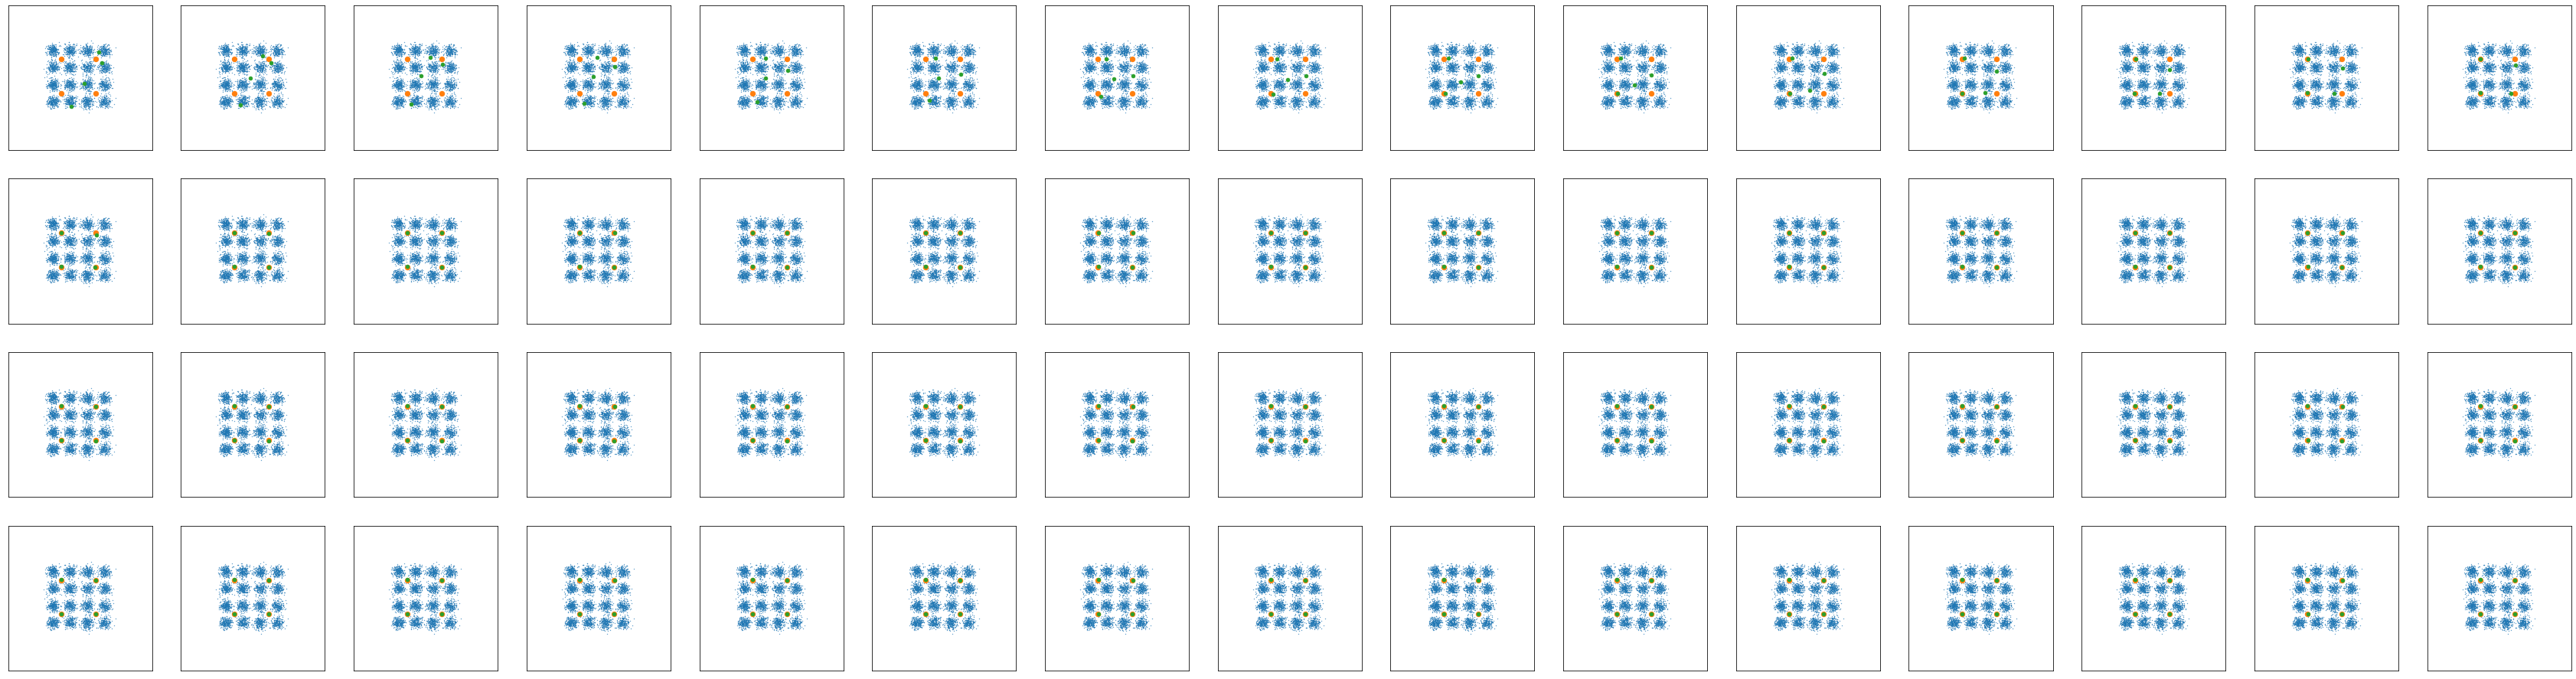

Variational EM final data log likelihood:  -6.793014764957969


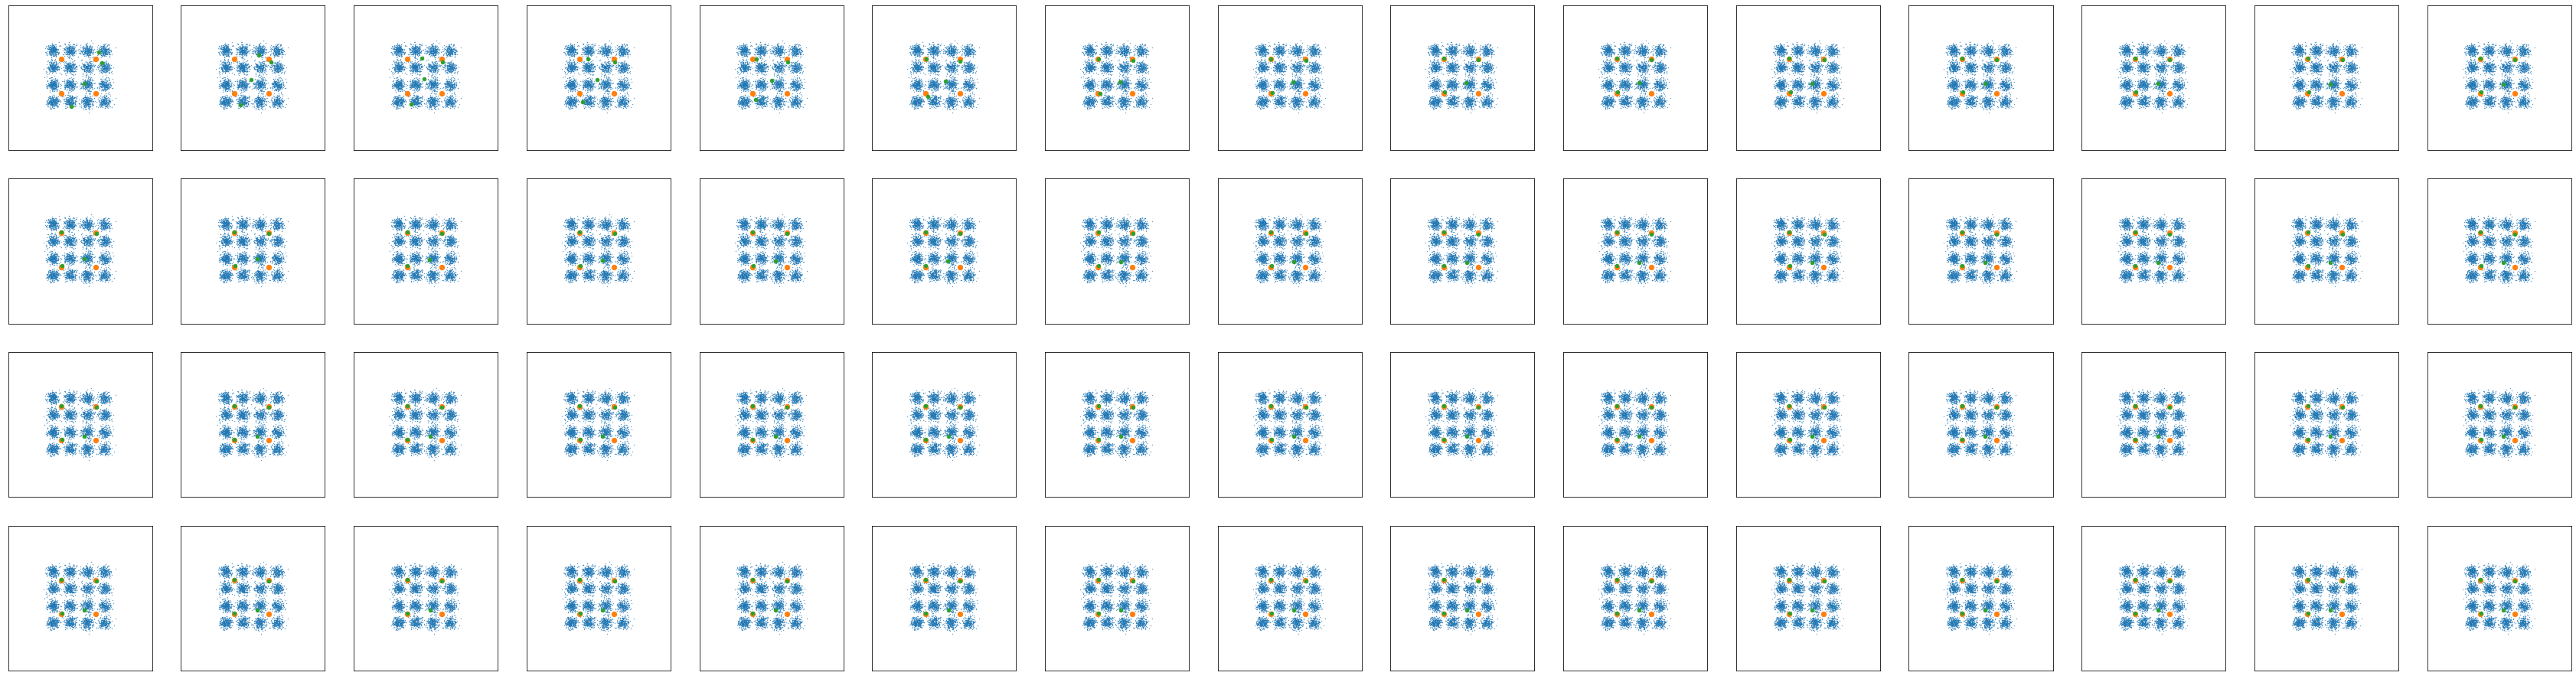

100%|███| 60/60 [06:20<00:00,  6.34s/it]


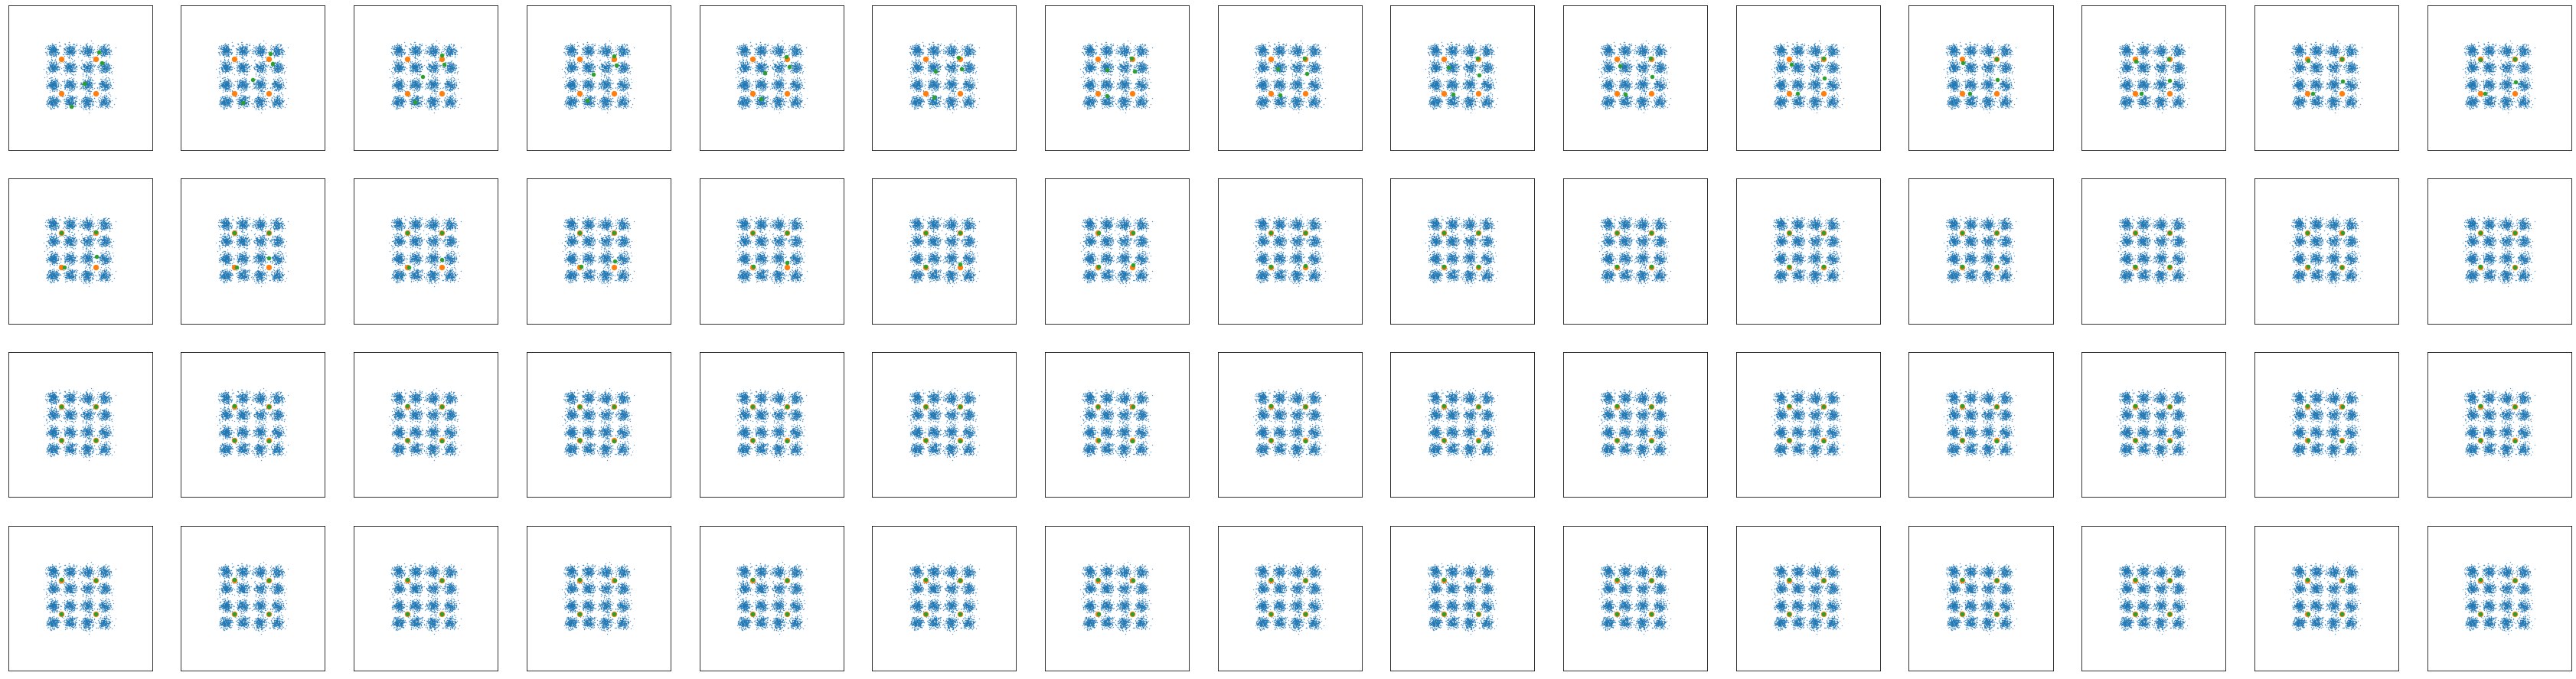

Final GFN-EM data log likelihood:  -5.600066630948679
Average exact EM data log likelihood:  -5.6000578247303805
Average variational EM data log likelihood:  -6.793014764957969
Average GFN-EM data log likelihood:  -5.600066630948679


In [84]:
em_iterations = 60
gfn_iterations = 60
gt_data_log_likelihoods = []
exact_data_log_likelihoods = []
exact_megacomponent_means_list = []
variational_data_log_likelihoods = []
variational_megacomponent_means_list = []
gfn_data_log_likelihoods = []
gfn_megacomponent_means_list = []

for init in initialization_list:
  # Use the same data for each method
  data = sample_data(4000)
  data_tensor = T.tensor(data, dtype=T.float32)

  # Compute data log likelihood for the ground truth means
  gt_data_log_likelihood = data_log_likelihood(data, gt_megacomponent_means)
  gt_data_log_likelihoods.append(gt_data_log_likelihoods)
  print('Ground truth data log likelihood: ', gt_data_log_likelihood)

  # Run all methods
  exact_megacomponent_means, _, exact_data_log_likelihood  = exact_EM(init, em_iterations)
  variational_megacomponent_means, _, variational_data_log_likelihood  = variational_EM(init, em_iterations)
  gfn_megacomponent_means, gfn_data_log_likelihood, _ = run_GFN_EM(init, gfn_iterations)

  # Save log-likelihood and final megacomponent means for each method
  exact_data_log_likelihoods.append(exact_data_log_likelihood)
  exact_megacomponent_means_list.append(exact_megacomponent_means)
  variational_data_log_likelihoods.append(variational_data_log_likelihood)
  variational_megacomponent_means_list.append(variational_megacomponent_means)
  gfn_data_log_likelihoods.append(gfn_data_log_likelihood)
  gfn_megacomponent_means_list.append(gfn_megacomponent_means)

exact_mean_ll = np.array(exact_data_log_likelihoods).mean()
variational_mean_ll = np.array(variational_data_log_likelihoods).mean()
gfn_mean_ll = np.array(gfn_data_log_likelihoods).mean()

print('Average exact EM data log likelihood: ', exact_mean_ll)
print('Average variational EM data log likelihood: ', variational_mean_ll)
print('Average GFN-EM data log likelihood: ', gfn_mean_ll)

## Visualizations for posteriors + means

### Posterior visualization (generates Figure 2 in the paper)

In [85]:
# Pick an estimate of megacomponent means that illustrates ambiguity in the posterior
megacomponent_means_for_posterior_vis = np.array([[-2.47049352,  0.38887989], # purple cluster
                                                 [ 1.14934963, -0.60384374], # blue cluster
                                                 [-0.19642042, -1.42613101], # green cluster
                                                 [0.21112086,  1.14786994 ]]) # yellow cluster
print(megacomponent_means_for_posterior_vis)

[[-2.47049352  0.38887989]
 [ 1.14934963 -0.60384374]
 [-0.19642042 -1.42613101]
 [ 0.21112086  1.14786994]]


In [95]:
# Run only a single E-step for each method. Note that final data log likelihoods will be bad
# because there are no M-steps, but it will let us visualize the output of the E-step.
# Recommend increasing iterations_per_e_step to 10k or 100k so that GFN trains to convergence during a single E-step.
_, qij_to_visualize, _ = exact_EM(megacomponent_means_for_posterior_vis, 1, e_step_only=True)
_, (qi_to_visualize, qj_to_visualize), _ = variational_EM(megacomponent_means_for_posterior_vis, 1, e_step_only=True)
_, ll, gfn_posterior = run_GFN_EM(megacomponent_means_for_posterior_vis, 1, e_step_only=True)

Exact EM final data log likelihood:  -8.871034955938345


<Figure size 72x1152 with 0 Axes>

Variational EM final data log likelihood:  -8.871034955938345


<Figure size 72x1152 with 0 Axes>

100%|█████| 1/1 [01:00<00:00, 60.75s/it]


<Figure size 72x1152 with 0 Axes>

Final GFN-EM data log likelihood:  -8.871034955938345


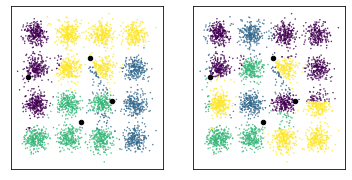

In [96]:
# For the most likely (i,j) pair for each data point, separate it into i -> best_i and j -> best_j
best_exact_i, best_exact_j = get_best_separate_latents(qij_to_visualize)
plot_posterior(data, megacomponent_means_for_posterior_vis, best_exact_i, best_exact_j)

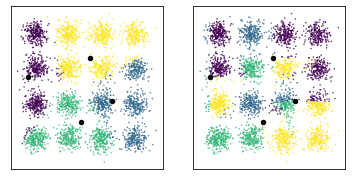

In [97]:
best_var_i = qi_to_visualize.argmax(1)
best_var_j = qj_to_visualize.argmax(1)
plot_posterior(data, megacomponent_means_for_posterior_vis, best_var_i, best_var_j)


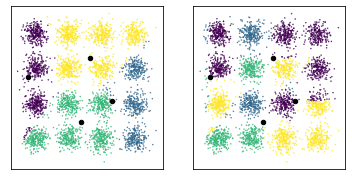

In [98]:
best_gfn_i, best_gfn_j = get_best_separate_latents(gfn_posterior)
plot_posterior(data, megacomponent_means_for_posterior_vis, best_gfn_i, best_gfn_j)

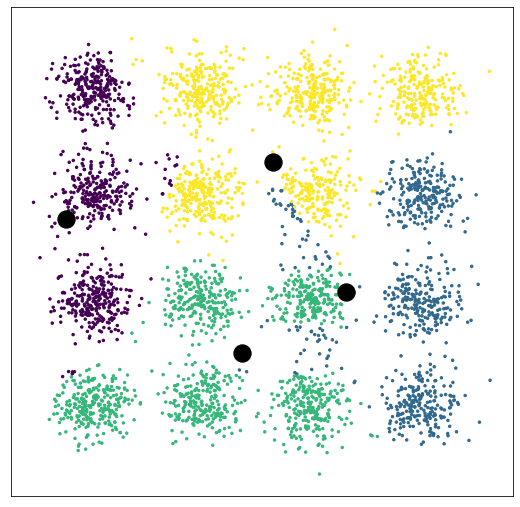

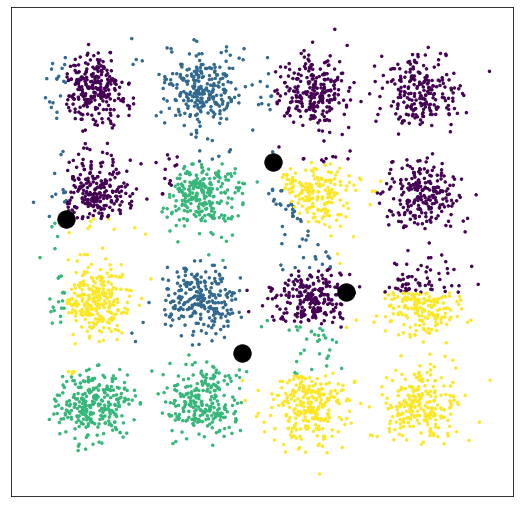

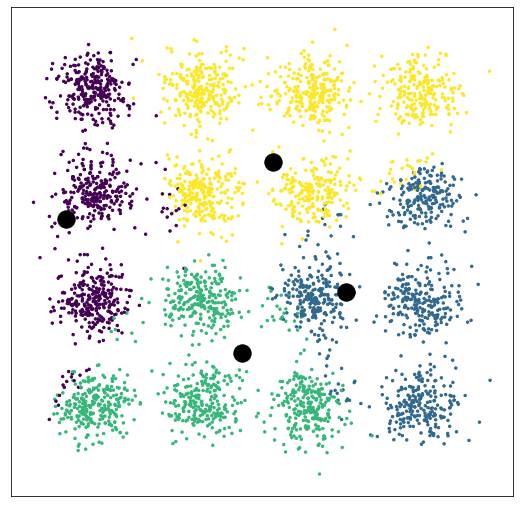

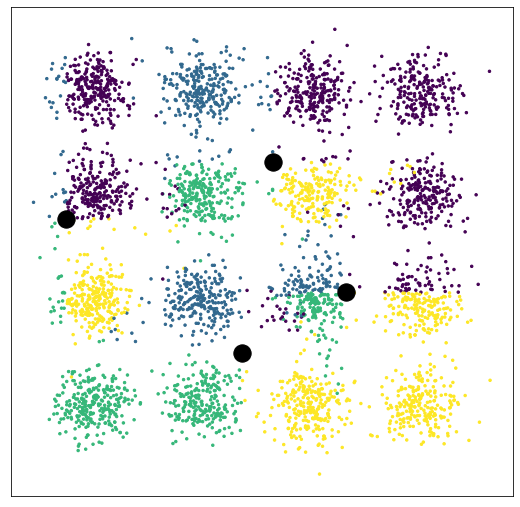

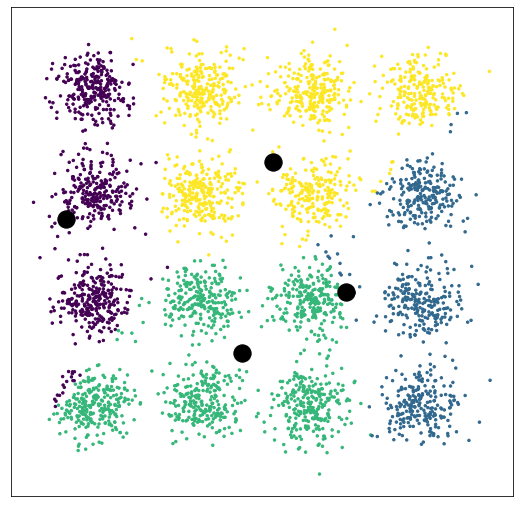

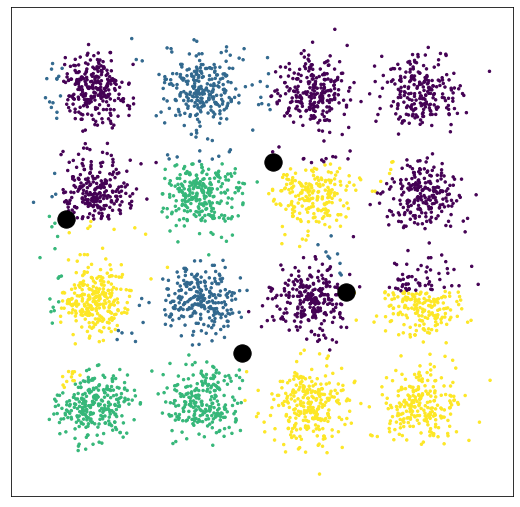

In [100]:
plot_posterior_panel(data, megacomponent_means_for_posterior_vis, best_exact_i)
plot_posterior_panel(data, megacomponent_means_for_posterior_vis, best_exact_j)
plot_posterior_panel(data, megacomponent_means_for_posterior_vis, best_var_i)
plot_posterior_panel(data, megacomponent_means_for_posterior_vis, best_var_j)
plot_posterior_panel(data, megacomponent_means_for_posterior_vis, best_gfn_i)
plot_posterior_panel(data, megacomponent_means_for_posterior_vis, best_gfn_j)

### Means visualization (generate Figure 3 in the paper)

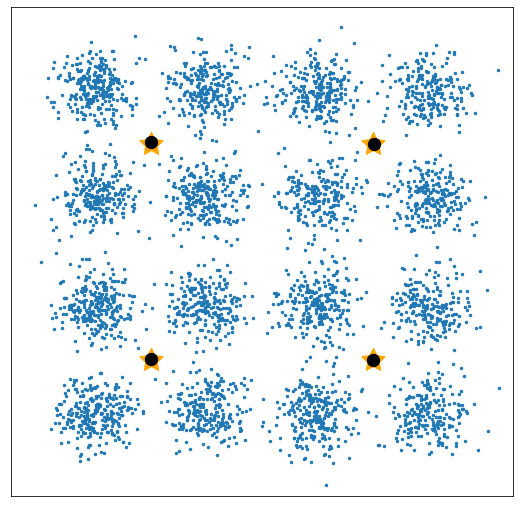

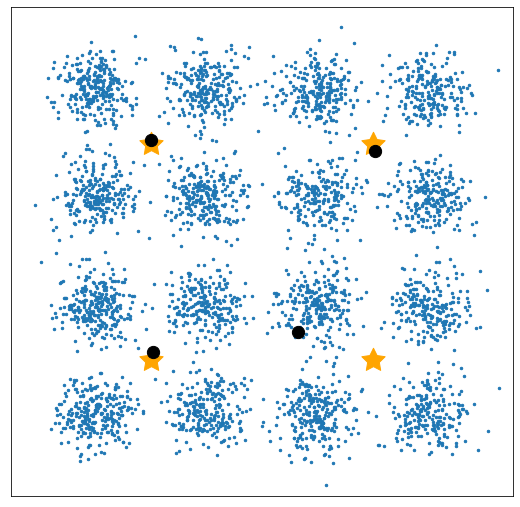

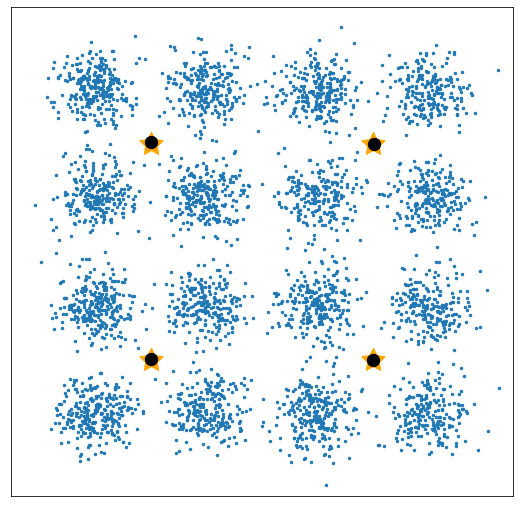

In [101]:
# Plot ground truth and final means for each method
plot_means(exact_megacomponent_means)
plot_means(variational_megacomponent_means)
plot_means(gfn_megacomponent_means.detach().numpy())